In [14]:
import pandas as pd
import os
import json
%matplotlib inline
from matplotlib import pyplot as plt
import scispacy
import spacy
import en_core_sci_lg
import numpy as np
from rank_bm25 import BM25Plus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# df.sha.fillna("", inplace=True)
df = pd.read_csv("./CORD-19-research-challenge/metadata.csv")
df[df.has_pmc_xml_parse == True]

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50802,zdr0f2uq,aac7a557d56de4ec3180fec38514eec284d03e0e; 313d...,PMC,Exploitation of glycosylation in enveloped vir...,10.1016/j.bbagen.2019.05.012,PMC6686077,31121217.0,cc-by,Glycosylation is a ubiquitous post-translation...,2019-10-10,"Watanabe, Yasunori; Bowden, Thomas A.; Wilson,...",Biochim Biophys Acta Gen Subj,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
50809,9j85qgmw,c3e0344db3d8c5e2bb35c3d001d480f3890656f2; ae8c...,PMC,Lack of detection of Middle East respiratory s...,10.1002/2052-2975.34,PMC4184620,25356335.0,cc-by-nc-nd,Surveillance of Middle East respiratory syndro...,2014-01-28,"Martínez, M J; Marcos, M A; Gonzalo, V; Zborom...",New Microbes New Infect,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
50841,q4r36tpw,83cfd4e4f2ba744bccc85d7da2fe54157ee19136; 3069...,PMC,Beneficial effects of Houttuynia cordata polys...,10.1016/j.apsb.2017.11.003,PMC5925397,29719782.0,cc-by-nc-nd,Houttuynia cordata Thunb. is a traditional her...,2017-12-08,"Lu, Yan; Jiang, Yun; Ling, Lijun; Zhang, Yunyi...",Acta Pharm Sin B,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
50842,w5q1mq02,NaN,PMC,Lack of maternal–fetal SARS-CoV-2 transmission,10.1038/s41591-020-0810-y,PMC7096028,32161408.0,no-cc,NaN,2020-03-11,"Stower, Hannah",Nat Med,NaN,#8063,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...


In [4]:
root_folder = "CORD-19-research-challenge"
#get full text
def get_full_text(paper):
    license = paper["full_text_file"]
    if paper["has_pdf_parse"]:
        paper_type = "pdf_json"
        file_names = str(paper.sha).split("; ")
        suffix = ".json"
    elif paper["has_pmc_xml_parse"]:
        paper_type = "pmc_json"
        file_names = str(paper.pmcid).split("; ")
        suffix = ".xml.json"
    else:
        return ""
    full_text = []
    for file in file_names:
        file_path = os.path.join(root_folder, license, license, paper_type, file+suffix)
        with open(file_path) as json_file:
            data = json.load(json_file)
            for section in ["abstract", "body_text"]:
                if section in data:
                    for paragraph in data[section]:
                        full_text.append(paragraph["text"])
            
    return " ".join(full_text)


In [5]:
df['text'] = df.apply(lambda x: get_full_text(x), axis=1)
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,text
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,"Background: Rhinovirus, the most common cause ..."
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,comment reviews reports deposited research int...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,"The message was dated Tuesday, 2 June 2003. ""F..."
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,The human leukocyte antigen (HLA) system is wi...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,Background: An epidemic of a Severe Acute Resp...


In [7]:
df.iloc[16188]["text"]

'Whereas P-bodies are intimately linked to the cytoplasmic RNA decay machinery, stress granules harbor stalled translation initiation complexes that accumulate upon stress-induced translation arrest. In this Chapter, we reflect on the relationship between P-bodies and stress granules. In mammalian cells, the two structures can be clearly distinguished from each other using specific protein or RNA markers, but they also share many proteins and mRNAs. While the formation of P-bodies and stress granules is coordinately triggered by stress, their assembly appears to be regulated independently by different pathways. Under certain types of stress, P-bodies frequently dock with stress granules, and overexpressing certain proteins that localize to both structures can cause P-body/stress granule fusion. Currently available data suggest that these self-assembling compartments are controlled by flux of mRNAs within the cytoplasm, and that their assembly mirrors the translation and degradation rat

In [8]:
df.shape

(51078, 19)

In [6]:
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])

In [9]:
def tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [41]:
doc = tokenizer(df.iloc[16188]["text"])

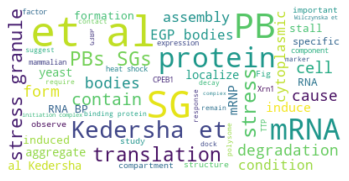

In [12]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, max_words=60, background_color="white").generate(" ".join(doc))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df.text.to_numpy())

In [43]:
def get_related_documents(query, k):
    query_tokenized = tokenizer(query)
    query_vec = vectorizer.transform([" ".join(query_tokenized)])
    
    results = cosine_similarity(vectors,query_vec)
    results = results.flatten()
    
    doc_indexes = np.argsort(results)[::-1]
    return df.iloc[doc_indexes][:k]

In [48]:
query = "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery."
get_related_documents(query, 5)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,text
6050,v6fistq1,4589d4013cf69c396e0fdb67131022fc11119654,PMC,Association between the Severity of Influenza ...,10.1371/journal.pone.0148506,PMC4757028,26885816.0,cc-by,"BACKGROUND: In early 2013, a novel avian-origi...",2016-02-17,"Virlogeux, Victor; Yang, Juan; Fang, Vicky J.;...",PLoS One,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,"In early 2013, a novel avian-origin influenza ..."
6075,k8kgtzrx,68a2a48d4c67318b019928c9e1d1e896153a6cd2; b703...,PMC,Association between Severity of MERS-CoV Infec...,10.3201/eid2203.151437,PMC4766874,26890291.0,no-cc,We analyzed data for 170 patients in South Kor...,2016-03-10,"Virlogeux, Victor; Park, Minah; Wu, Joseph T.;...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,events cannot be directly observed. If patient...
39430,iicbaevw,31e1b495e358bdfb9ac295b4e1cdd8052056499d; 3862...,Elsevier,Incubation periods of acute respiratory viral ...,10.1016/s1473-3099(09)70069-6,PMC4327893,19393959.0,els-covid,Summary Knowledge of the incubation period is ...,2009-05-31,"Lessler, Justin; Reich, Nicholas G; Brookmeyer...",The Lancet Infectious Diseases,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/s1473-3099(09)70069-6,Knowledge of the incubation period is essentia...
15199,v24wsn04,c97de2b77c5593f9246815623b82f6c295c6d257,PMC,Incubation Period of Shiga Toxin–Producing Esc...,10.1093/epirev/mxz001,PMC7108491,31616910.0,no-cc,Shiga toxin–producing Escherichia coli are pat...,2019-10-16,"Awofisayo-Okuyelu, Adedoyin; Brainard, Julii; ...",Epidemiol Rev,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Shiga toxin-producing Escherichia coli are pat...
3692,553cjp9f,599f44a88bfd9fcd7cc5b03f3b0bf01c9b3c5ba8,PMC,Incubation periods of viral gastroenteritis: a...,10.1186/1471-2334-13-446,PMC3849296,24066865.0,cc-by,BACKGROUND: Accurate knowledge of incubation p...,2013-09-25,"Lee, Rachel M; Lessler, Justin; Lee, Rose A; R...",BMC Infect Dis,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,Background: Accurate knowledge of incubation p...
2275,13xmmin1,24de65541e25ca372d5fb686b733b45a1dd5c0b6,PMC,Multiple Contact Dates and SARS Incubation Per...,10.3201/eid1002.030426,PMC3322923,15030684.0,no-cc,Many severe acute respiratory syndrome (SARS) ...,2004-02-10,"Meltzer, Martin I.",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,T he appearance and rapid spread of severe acu...
15375,4h9j9bw2,f5d0016e273f4c10d43dff7ed9f4eaf3bcf7aa42,PMC,Refined Estimate of the Incubation Period of S...,10.1093/aje/kwj034,PMC7109871,16339050.0,no-cc,Many epidemiologists have agreed that a refine...,2006-02-01,"Cai, Quan-Cai; Xu, Qin-Feng; Xu, Jian-Ming; Gu...",Am J Epidemiol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Many epidemiologists have agreed that a refine...
